# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip install scikit-optimize
from skopt import BayesSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
# Membaca dataset Customer hasil Clustering dan menampilkan 5 baris pertama
df = pd.read_csv('https://raw.githubusercontent.com/annisaast/ProyekMachineLearning/main/shopping_trends_updated_with_cluster.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Cluster
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,2
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,2
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,2
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,0
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,2


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [3]:
# Mengambil kolom fitur yang digunakan dan hasil dari proses clustering
df_class = df[['Purchase Amount (USD)', 'Review Rating', 'Category', 'Discount Applied', 'Frequency of Purchases', 'Cluster']]
df_class.head()

,Purchase Amount (USD),Review Rating,Category,Discount Applied,Frequency of Purchases,Cluster
0,53,3.1,Clothing,Yes,Fortnightly,2
1,64,3.1,Clothing,Yes,Fortnightly,2
2,73,3.1,Clothing,Yes,Weekly,2
3,90,3.5,Footwear,Yes,Weekly,0
4,49,2.7,Clothing,Yes,Annually,2


<ipython-input-4-6ee357a37280>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df_class, palette='Pastel1')


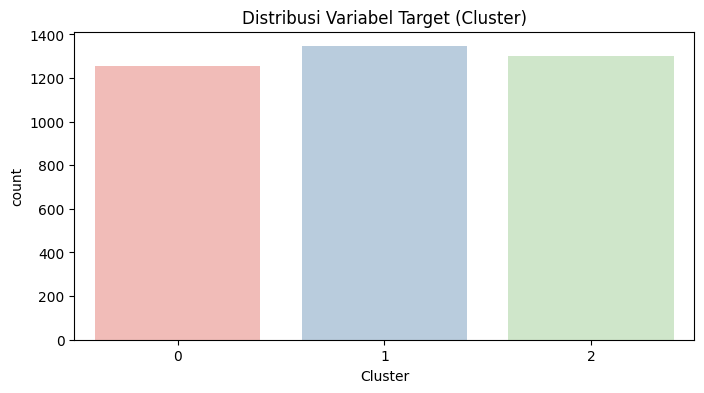

In [4]:
# Visualisasi distribusi variabel target
plt.figure(figsize=(8, 4))
sns.countplot(x='Cluster', data=df_class, palette='Pastel1')
plt.title('Distribusi Variabel Target (Cluster)')
plt.show()

In [5]:
# Copy df_binned dari df_class
df_binned = copy.deepcopy(df_class)

#["Very Low", "Low", "Medium", "High", "Very High"]
# Binning data Purchase Amount (USD)
bins_purchase = 3
labels_purchase = ["Low", "Medium", "High"]
df_binned['Purchase Amount (USD)'] = pd.qcut(df_binned['Purchase Amount (USD)'], q=bins_purchase, labels=labels_purchase)

# Binning data Review Rating
bins_rating = 5
labels_rating = ["Very Low", "Low", "Medium", "High", "Very High"]
df_binned['Review Rating'] = pd.qcut(df_binned['Review Rating'], q=bins_rating, labels=labels_rating)

# Menampilkan data setelah Binning
df_binned.head()

,Purchase Amount (USD),Review Rating,Category,Discount Applied,Frequency of Purchases,Cluster
0,Medium,Low,Clothing,Yes,Fortnightly,2
1,Medium,Low,Clothing,Yes,Fortnightly,2
2,Medium,Low,Clothing,Yes,Weekly,2
3,High,Low,Footwear,Yes,Weekly,0
4,Medium,Very Low,Clothing,Yes,Annually,2


In [6]:
df_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Purchase Amount (USD)   3900 non-null   category
 1   Review Rating           3900 non-null   category
 2   Category                3900 non-null   object  
 3   Discount Applied        3900 non-null   object  
 4   Frequency of Purchases  3900 non-null   object  
 5   Cluster                 3900 non-null   int64   
dtypes: category(2), int64(1), object(3)
memory usage: 130.0+ KB


In [7]:
# Encoding Data Kategorikal
category_features = df_binned.select_dtypes(include=['object', 'category']).columns
df_binned[category_features]

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()
df_lencoder = pd.DataFrame(df_binned)

for col in category_features:
    df_lencoder[col] = label_encoder.fit_transform(df_binned[col])

# Menampilkan hasil data teratas
df_lencoder.head()

,Purchase Amount (USD),Review Rating,Category,Discount Applied,Frequency of Purchases,Cluster
0,2,1,1,1,3,2
1,2,1,1,1,3,2
2,2,1,1,1,6,2
3,0,1,2,1,6,0
4,2,4,1,1,0,2


In [8]:
df_lencoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Purchase Amount (USD)   3900 non-null   int64
 1   Review Rating           3900 non-null   int64
 2   Category                3900 non-null   int64
 3   Discount Applied        3900 non-null   int64
 4   Frequency of Purchases  3900 non-null   int64
 5   Cluster                 3900 non-null   int64
dtypes: int64(6)
memory usage: 182.9 KB


In [9]:
# Pisahkan fitur (X) dan target (y)
X = df_lencoder.drop(columns=['Cluster'])
y = df_lencoder['Cluster']

# Split df_lencoder menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Mengubah y_train dan y_test menjadi kategori diskrit menggunakan pd.cut
# Misalnya, membagi menjadi 3 kategori berdasarkan rentang nilai
bins = 3
labels = ['0', '1', '2']

y_train = pd.cut(y_train, bins=bins, labels=labels)
y_test = pd.cut(y_test, bins=bins, labels=labels)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(2730, 5), y_train=(2730,)
Testing set shape: X_test=(1170, 5), y_test=(1170,)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [10]:
# Bagian 1: Pelatihan Model
# Definisikan setiap klasifikasi secara terpisah
knn = KNeighborsClassifier().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

print("Model training selesai.")

Model training selesai.


Tulis narasi atau penjelasan algoritma yang Anda gunakan.
1. K-Nearest Neighbors (KNN): Klasifikasi titik data baru berdasarkan label mayoritas dari tetangga terdekatnya dalam ruang fitur menggunakan jarak antar data yang diklasifikasikan.
2. Random Forest: Klasifikasi yang membangun dan menggabungkan banyak pohon keputusan (Decision Tree) untuk membuat prediksi yang lebih stabil dan akurat.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

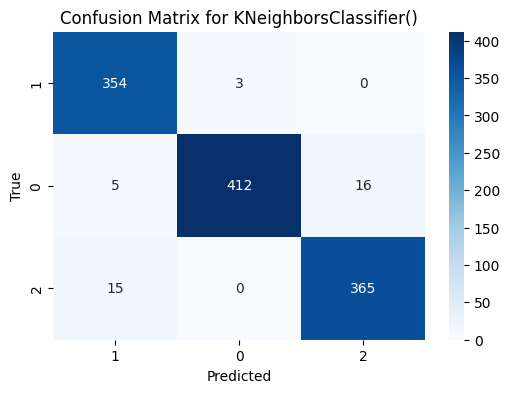

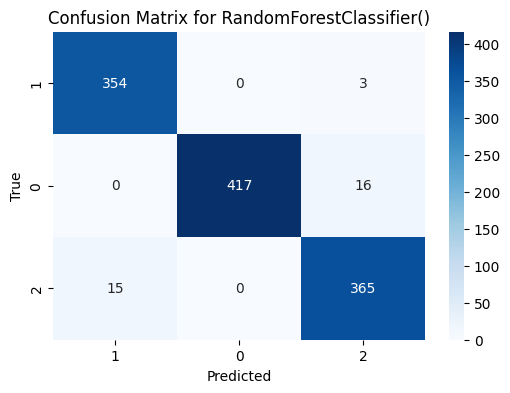

                 Model  Accuracy  Precision    Recall  F1-Score
0  K-Nearest Neighbors  0.966667   0.965767  0.967875  0.966499
1        Random Forest  0.970940   0.969957  0.971724  0.970627


In [11]:
# Fungsi untuk mengevaluasi dan menampilkan confusion matrix
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Cek apakah matriks kebingungannya 2x2 atau lebih besar (untuk klasifikasi multi-kelas)
    if cm.shape == (2, 2):  # Klasifikasi biner
        tn, fp, fn, tp = cm.ravel()
    else:  # Klasifikasi multi-kelas
        tn, fp, fn, tp = None, None, None, None

    # Menghitung metrik dengan menggunakan 'average' yang sesuai jika multi-kelas
    results = {
        'Confusion Matrix': cm,
        'True Positive (TP)': tp if tp is not None else None,
        'False Positive (FP)': fp if fp is not None else None,
        'False Negative (FN)': fn if fn is not None else None,
        'True Negative (TN)': tn if tn is not None else None,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_pred, average='macro')
    }

    # Menampilkan confusion matrix dengan visualisasi
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return results

# Mengevaluasi setiap model dan mengumpulkan hasilnya
results = {
    'K-Nearest Neighbors': evaluate_model(knn, X_test, y_test),
    'Random Forest': evaluate_model(rf, X_test, y_test)
}

# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Isi DataFrame dengan hasil
rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Konversi daftar kamus ke DataFrame
summary_df = pd.DataFrame(rows)

# Tampilkan DataFrame
print(summary_df)

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.
*   Berdasarkan hasil evaluasi, dapat dilihat bahwa Accuracy, Precision, Recall dan F1-Score dari Random Forest lebih besar daripada Accuracy, Precision, Recall dan F1-Score dari KNN.
*   Kedua algoritma menunjukkan kinerja yang sangat baik, Random Forest memberikan hasil yang sedikit lebih baik di semua metrik evaluasi dibandingkan dengan KNN. Hal ini menunjukkan bahwa Random Forest lebih efektif dalam menangani variasi data dan memberikan prediksi yang lebih akurat serta lebih baik dalam menangani kasus positif.





## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [12]:
# Tuning Random Forest Menggunakan Grid Search
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Inisialisasi GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Output hasil terbaik
print(f"Best Parameters for Random Forest (Grid Search): {rf_grid_search.best_params_}")
best_rf_grid = rf_grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters for Random Forest (Grid Search): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [14]:
# Tuning Random Forest Menggunakan Random Search
rf_param_random = {
    'n_estimators': np.linspace(100, 500, 5, dtype=int),
    'max_depth': np.linspace(10, 50, 5, dtype=int),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Inisialisasi RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_random, n_iter=20, cv=3, n_jobs=-1, verbose=2, random_state=42)
rf_random_search.fit(X_train, y_train)

# Output hasil terbaik
print(f"Best Parameters for Random Forest (Random Search): {rf_random_search.best_params_}")
best_rf_random = rf_random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for Random Forest (Random Search): {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 50}


In [16]:
# Tuning Random Forest Menggunakan Bayesian Optimization
rf_param_bayesian = {
    'n_estimators': (100, 500),
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': ['sqrt', 'log2']
}

# Inisialisasi BayesSearchCV
rf_bayes_search = BayesSearchCV(estimator=rf, search_spaces=rf_param_bayesian, n_iter=20, cv=3, n_jobs=-1, verbose=2, random_state=42)
rf_bayes_search.fit(X_train, y_train)

# Output hasil terbaik
print(f"Best Parameters for Random Forest (Bayesian Optimization): {rf_bayes_search.best_params_}")
best_rf_bayes = rf_bayes_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

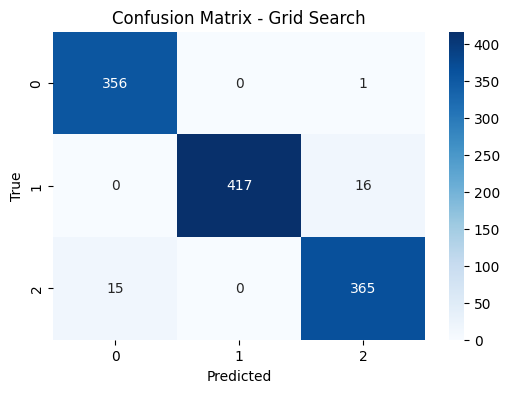

Ringkasan Hasil Evaluasi Tuning Grid Search:
           0         1
0   Accuracy  0.972650
1  Precision  0.971689
2     Recall  0.973591
3   F1-Score  0.972401


In [13]:
# Evaluasi Tuning Menggunakan Grid Search
grid_search_score = best_rf_grid.score(X_test, y_test)
y_pred_grid = best_rf_grid.predict(X_test)
precision_grid = precision_score(y_test, y_pred_grid, average='macro')
recall_grid = recall_score(y_test, y_pred_grid, average='macro')
f1_grid = f1_score(y_test, y_pred_grid, average='macro')

# Fungsi untuk menampilkan confusion matrix menggunakan heatmap
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Menampilkan Confusion Matrix untuk setiap model menggunakan heatmap
plot_confusion_matrix(y_test, y_pred_grid, 'Grid Search')

# Menyusun Rangkuman Hasil Evaluasi Setelah Tuning
grid_evaluation_results = [
    ['Accuracy', grid_search_score],
    ['Precision', precision_grid],
    ['Recall', recall_grid],
    ['F1-Score', f1_grid]
]

# Mengubah list menjadi DataFrame
grid_evaluation_df = pd.DataFrame(grid_evaluation_results)

# Menampilkan ringkasan hasil evaluasi
print("Ringkasan Hasil Evaluasi Tuning Grid Search:")
print(grid_evaluation_df)

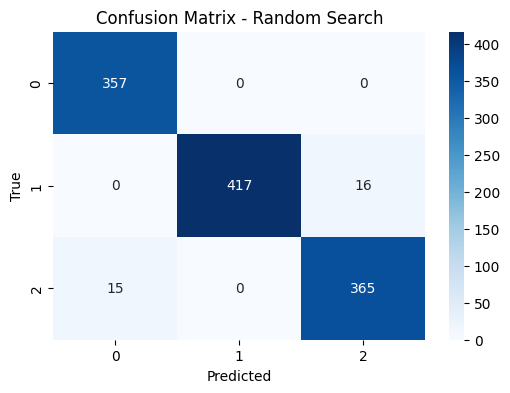

Ringkasan Hasil Evaluasi Tuning Random Search:
           0         1
0   Accuracy  0.973504
1  Precision  0.972561
2     Recall  0.974525
3   F1-Score  0.973288


In [15]:
# Evaluasi Tuning Menggunakan Random Search
random_search_score = best_rf_random.score(X_test, y_test)
y_pred_random = best_rf_random.predict(X_test)
precision_random = precision_score(y_test, y_pred_random, average='macro')
recall_random = recall_score(y_test, y_pred_random, average='macro')
f1_random = f1_score(y_test, y_pred_random, average='macro')

# Fungsi untuk menampilkan confusion matrix menggunakan heatmap
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Menampilkan Confusion Matrix untuk setiap model menggunakan heatmap
plot_confusion_matrix(y_test, y_pred_random, 'Random Search')

# Menyusun Rangkuman Hasil Evaluasi Setelah Tuning
random_evaluation_results = [
    ['Accuracy', random_search_score],
    ['Precision', precision_random],
    ['Recall', recall_random],
    ['F1-Score', f1_random]
]

# Mengubah list menjadi DataFrame
random_evaluation_df = pd.DataFrame(random_evaluation_results)

# Menampilkan ringkasan hasil evaluasi
print("Ringkasan Hasil Evaluasi Tuning Random Search:")
print(random_evaluation_df)

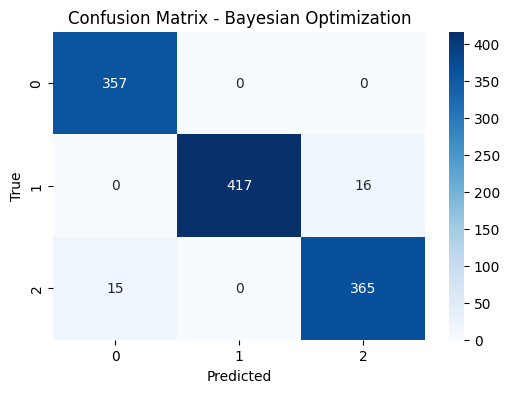

Ringkasan Hasil Evaluasi Tuning Bayesian Optimization:
           0         1
0   Accuracy  0.973504
1  Precision  0.972561
2     Recall  0.974525
3   F1-Score  0.973288


In [17]:
# Evaluasi Tuning Menggunakan Bayesian Optimization
bayes_search_score = best_rf_bayes.score(X_test, y_test)
y_pred_bayes = best_rf_bayes.predict(X_test)
precision_bayes = precision_score(y_test, y_pred_bayes, average='macro')
recall_bayes = recall_score(y_test, y_pred_bayes, average='macro')
f1_bayes = f1_score(y_test, y_pred_bayes, average='macro')

# Fungsi untuk menampilkan confusion matrix menggunakan heatmap
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Menampilkan Confusion Matrix untuk setiap model menggunakan heatmap
plot_confusion_matrix(y_test, y_pred_bayes, 'Bayesian Optimization')

# Menyusun Rangkuman Hasil Evaluasi Setelah Tuning
bayes_evaluation_results = [
    ['Accuracy', bayes_search_score],
    ['Precision', precision_bayes],
    ['Recall', recall_bayes],
    ['F1-Score', f1_bayes]
]

# Mengubah list menjadi DataFrame
bayes_evaluation_df = pd.DataFrame(bayes_evaluation_results)

# Menampilkan ringkasan hasil evaluasi
print("Ringkasan Hasil Evaluasi Tuning Bayesian Optimization:")
print(bayes_evaluation_df)

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

In [18]:
#Type your code here

Analisis Hasil Evaluasi
1. Perbandingan Sebelum dan Setelah Tuning: Sebelum tuning, model memiliki performa yang sangat baik dengan akurasi 97,09% dan F1-Score 97,06%. Setelah tuning, performa model mengalami peningkatan pada setiap metrik evaluasi untuk setiap metode hyperparameter tuning.
2. Perbandingan Metode Tuning
  *   Grid Search: mengalami peningkatan menjadi akurasi 97,26% dan F1-Score 97,24%.
  *   Random Search: mengalami peningkatan menjadi akurasi 97,35% dan F1-Score 97,33%
  *   Bayesian Optimization: mengalami peningkatan menjadi akurasi 97,35% dan F1-Score 97,33%
  *   Random Search dan Bayesian Optimization menghasilkan model yang lebih baik dibandingkan dengan Grid Search.









